In [1]:
# Import necessary packages

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

In [2]:
noise_dim = 100

In [3]:
# Generator
def make_generator_model():
    model = Sequential()
    model.add(Dense(15, activation='relu', input_dim=noise_dim))
    model.add(Dense(2, activation='linear'))
    return model
generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                1515      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32        
Total params: 1,547
Trainable params: 1,547
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Discriminator
def make_discriminator_model():
    model = Sequential()
    model.add(Dense(25, activation='relu',input_dim=2))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Optimizers and loss function
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

discriminator = make_discriminator_model()
generator = make_generator_model()

In [6]:
# Generator of real points
import random
import math
def generate_real_points(n):
    points = []
    for i in range(n):
        x = random.random()*7-(7/2)
        #y = x #
        y = math.sin(x)
        points.append((x,y))
    points = np.array(points)
    return points

In [9]:
# One step (epoch) of training
def do_step(batch_size):
    real_points = generate_real_points(batch_size)
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake points uning noise
        generated_points = generator(noise, training=True) 
        # check real and fake points with discriminator
        real_output = discriminator(real_points, training=True) 
        fake_output = discriminator(generated_points, training=True)
        # discriminator loss - based on the number of wrong classification
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # avg of both losses
        # generator loss - based of the number of fake points recognized by discriminator
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply gradients and update weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [7]:
# Visualization - generates 100 example real points and 100 example fake points and shows the plot
def show_results():
  print("Epoch",epoch,f"generator loss={gl:.3f},discriminator loss={dl:.3f}")
  num_examples_to_generate = 100
        
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  fake_points = generator(seed, training=False)
  plt.scatter(fake_points[:,0],fake_points[:,1] , label='fake')

  real_points = generate_real_points(num_examples_to_generate)
  plt.scatter(real_points[:,0],real_points[:,1], label='real')
  plt.legend()
  
  # red cross over each point classified as fake by the discriminator
  fake_prediction = discriminator.predict(fake_points)
  num_true_neg = 0
  for i in range(num_examples_to_generate):
    if fake_prediction[i]<0.5:
      plt.scatter(fake_points[i,0],fake_points[i,1],marker='.',color='red')
      num_true_neg += 1 

  real_prediction = discriminator.predict(real_points)
  num_false_neg = 0
  for i in range(num_examples_to_generate):
    if real_prediction[i]<0.5:
      plt.scatter(real_points[i,0],real_points[i,1],marker='.',color='red')
      num_false_neg += 1
  accuracy_real = (num_examples_to_generate-num_false_neg)/num_examples_to_generate
  accuracy_fake = (num_examples_to_generate-num_true_neg)/num_examples_to_generate
  # Accuracy of the discriminator
  print("Accuracy real",accuracy_real,"accuracy fake",accuracy_fake)
  plt.show()    

Epoch 0 generator loss=1.010,discriminator loss=0.742
Accuracy real 0.0 accuracy fake 0.0


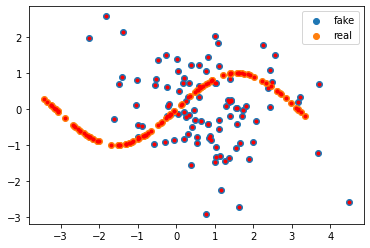

Epoch 100 generator loss=0.660,discriminator loss=0.663
Accuracy real 0.86 accuracy fake 0.64


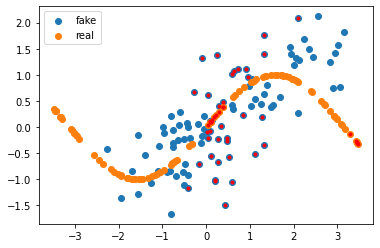

Epoch 200 generator loss=0.746,discriminator loss=0.694
Accuracy real 0.19 accuracy fake 0.18


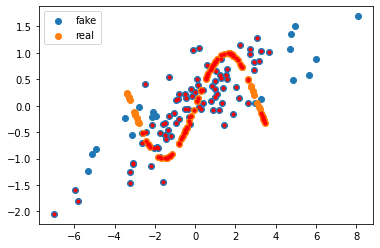

Epoch 300 generator loss=0.720,discriminator loss=0.687
Accuracy real 0.44 accuracy fake 0.24


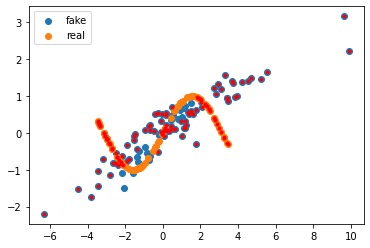

Epoch 400 generator loss=0.687,discriminator loss=0.685
Accuracy real 0.55 accuracy fake 0.68


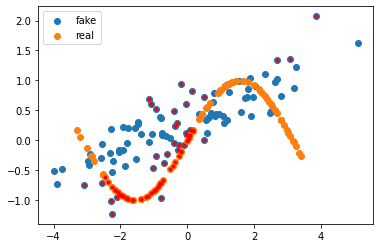

Epoch 500 generator loss=0.711,discriminator loss=0.679
Accuracy real 0.46 accuracy fake 0.36


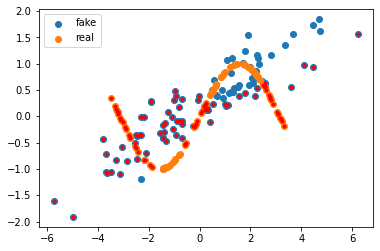

Epoch 600 generator loss=0.760,discriminator loss=0.643
Accuracy real 0.64 accuracy fake 0.44


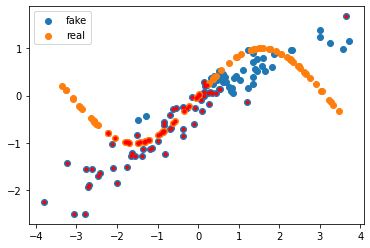

Epoch 700 generator loss=0.707,discriminator loss=0.699
Accuracy real 0.45 accuracy fake 0.35


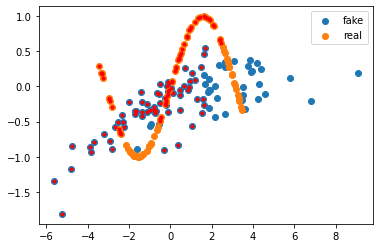

Epoch 800 generator loss=0.705,discriminator loss=0.688
Accuracy real 0.59 accuracy fake 0.3


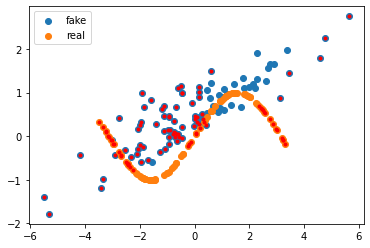

Epoch 900 generator loss=0.738,discriminator loss=0.652
Accuracy real 0.64 accuracy fake 0.34


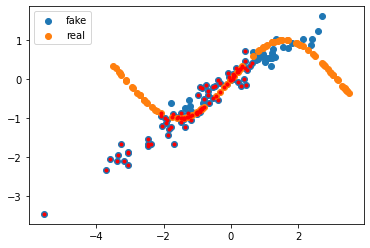

Epoch 1000 generator loss=0.743,discriminator loss=0.681
Accuracy real 0.48 accuracy fake 0.42


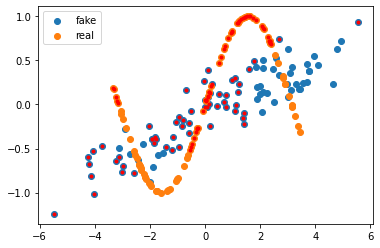

Epoch 1100 generator loss=0.718,discriminator loss=0.655
Accuracy real 0.7 accuracy fake 0.36


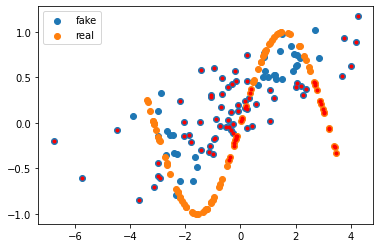

Epoch 1200 generator loss=0.720,discriminator loss=0.668
Accuracy real 0.7 accuracy fake 0.45


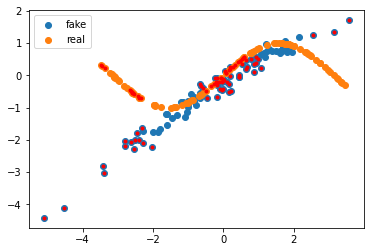

Epoch 1300 generator loss=0.758,discriminator loss=0.648
Accuracy real 0.6 accuracy fake 0.4


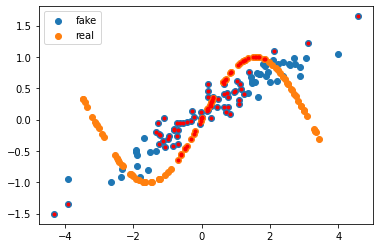

Epoch 1400 generator loss=0.858,discriminator loss=0.615
Accuracy real 0.57 accuracy fake 0.02


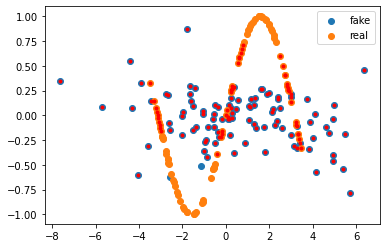

Epoch 1500 generator loss=0.707,discriminator loss=0.674
Accuracy real 0.57 accuracy fake 0.56


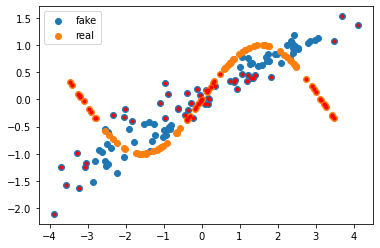

Epoch 1600 generator loss=0.798,discriminator loss=0.625
Accuracy real 0.8 accuracy fake 0.44


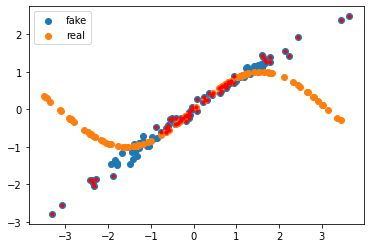

Epoch 1700 generator loss=0.779,discriminator loss=0.683
Accuracy real 0.36 accuracy fake 0.3


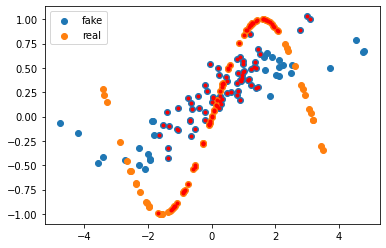

Epoch 1800 generator loss=0.882,discriminator loss=0.578
Accuracy real 0.63 accuracy fake 0.14


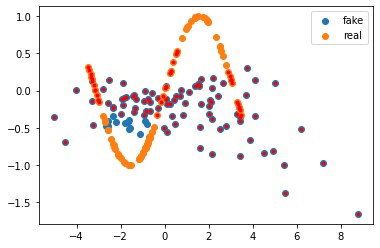

Epoch 1900 generator loss=0.753,discriminator loss=0.678
Accuracy real 0.62 accuracy fake 0.58


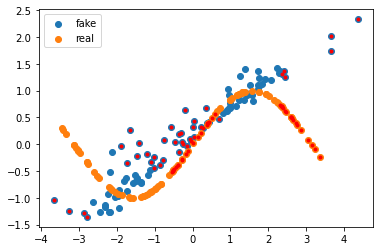

Epoch 2000 generator loss=0.830,discriminator loss=0.616
Accuracy real 0.79 accuracy fake 0.43


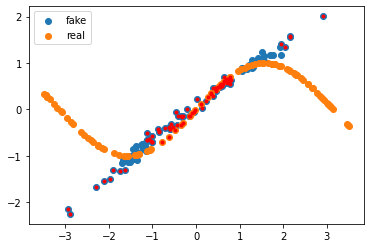

Epoch 2100 generator loss=0.804,discriminator loss=0.659
Accuracy real 0.58 accuracy fake 0.38


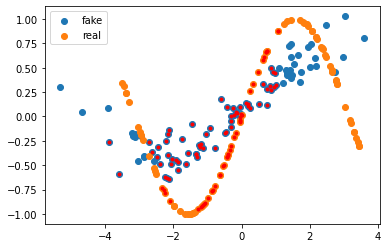

Epoch 2200 generator loss=0.858,discriminator loss=0.618
Accuracy real 0.69 accuracy fake 0.34


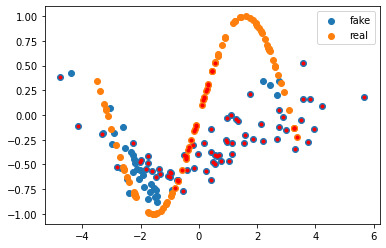

Epoch 2300 generator loss=0.752,discriminator loss=0.675
Accuracy real 0.57 accuracy fake 0.36


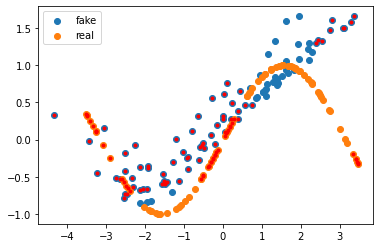

Epoch 2400 generator loss=0.764,discriminator loss=0.627
Accuracy real 0.67 accuracy fake 0.29


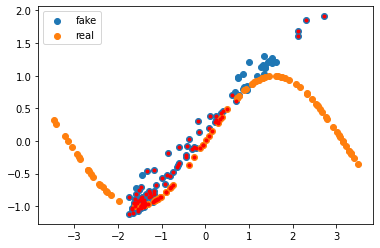

Epoch 2500 generator loss=0.750,discriminator loss=0.692
Accuracy real 0.38 accuracy fake 0.33


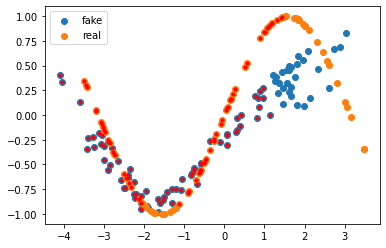

Epoch 2600 generator loss=0.767,discriminator loss=0.650
Accuracy real 0.44 accuracy fake 0.26


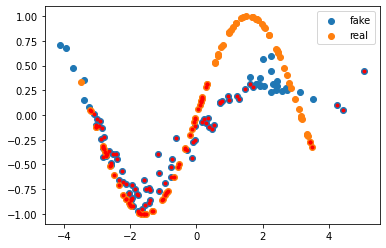

Epoch 2700 generator loss=0.680,discriminator loss=0.697
Accuracy real 0.74 accuracy fake 0.55


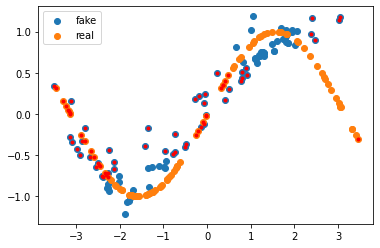

Epoch 2800 generator loss=0.749,discriminator loss=0.629
Accuracy real 0.55 accuracy fake 0.31


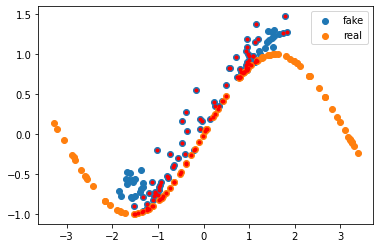

Epoch 2900 generator loss=0.722,discriminator loss=0.693
Accuracy real 0.41 accuracy fake 0.49


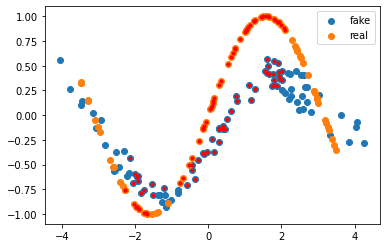

Epoch 3000 generator loss=0.741,discriminator loss=0.659
Accuracy real 0.51 accuracy fake 0.34


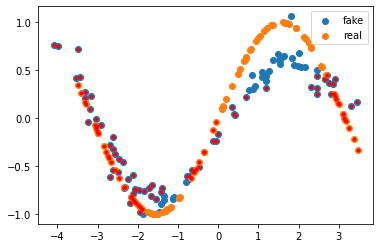

Epoch 3100 generator loss=0.705,discriminator loss=0.674
Accuracy real 0.79 accuracy fake 0.55


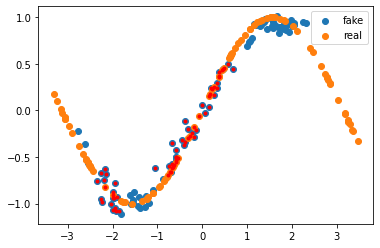

Epoch 3200 generator loss=0.715,discriminator loss=0.676
Accuracy real 0.56 accuracy fake 0.41


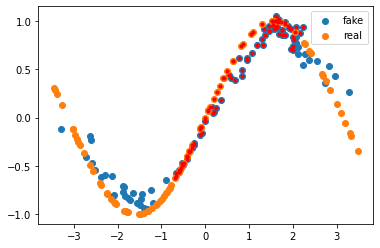

Epoch 3300 generator loss=0.733,discriminator loss=0.672
Accuracy real 0.38 accuracy fake 0.28


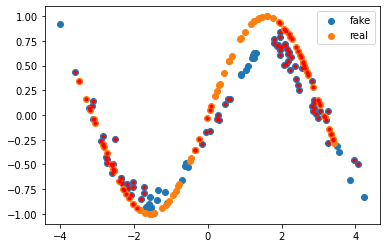

Epoch 3400 generator loss=0.691,discriminator loss=0.678
Accuracy real 0.64 accuracy fake 0.51


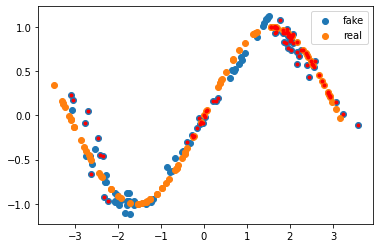

Epoch 3500 generator loss=0.722,discriminator loss=0.679
Accuracy real 0.47 accuracy fake 0.48


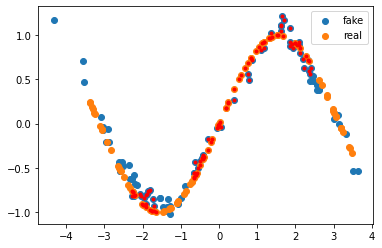

Epoch 3600 generator loss=0.702,discriminator loss=0.684
Accuracy real 0.61 accuracy fake 0.5


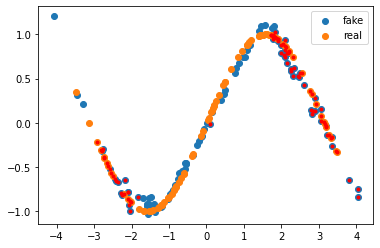

Epoch 3700 generator loss=0.720,discriminator loss=0.676
Accuracy real 0.61 accuracy fake 0.56


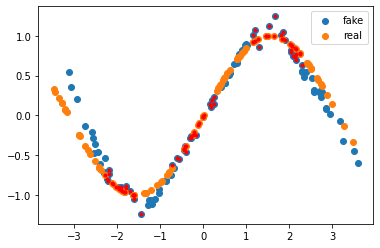

Epoch 3800 generator loss=0.688,discriminator loss=0.696
Accuracy real 0.61 accuracy fake 0.53


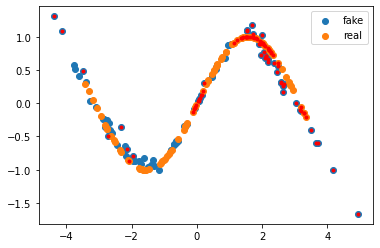

Epoch 3900 generator loss=0.700,discriminator loss=0.682
Accuracy real 0.63 accuracy fake 0.45


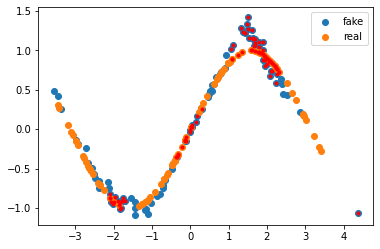

Epoch 4000 generator loss=0.695,discriminator loss=0.687
Accuracy real 0.57 accuracy fake 0.52


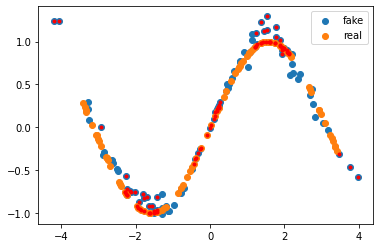

Epoch 4100 generator loss=0.694,discriminator loss=0.694
Accuracy real 0.61 accuracy fake 0.59


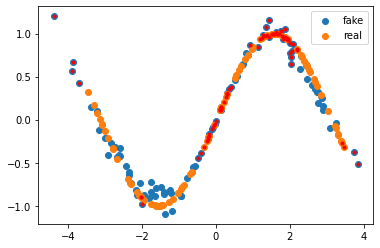

Epoch 4200 generator loss=0.695,discriminator loss=0.687
Accuracy real 0.65 accuracy fake 0.53


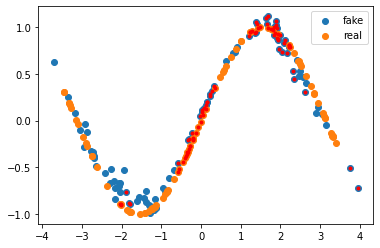

Epoch 4300 generator loss=0.699,discriminator loss=0.688
Accuracy real 0.67 accuracy fake 0.51


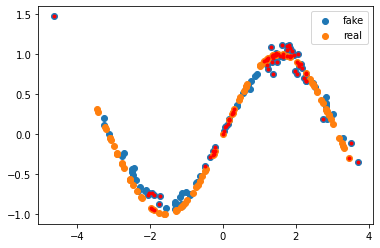

Epoch 4400 generator loss=0.696,discriminator loss=0.689
Accuracy real 0.55 accuracy fake 0.57


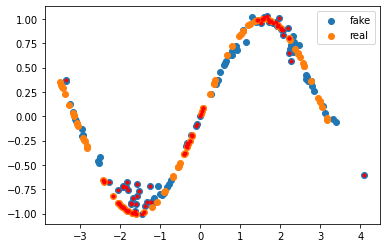

Epoch 4500 generator loss=0.711,discriminator loss=0.683
Accuracy real 0.56 accuracy fake 0.4


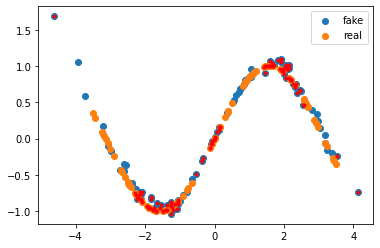

Epoch 4600 generator loss=0.702,discriminator loss=0.689
Accuracy real 0.6 accuracy fake 0.56


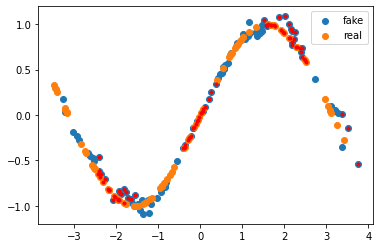

Epoch 4700 generator loss=0.700,discriminator loss=0.690
Accuracy real 0.46 accuracy fake 0.47


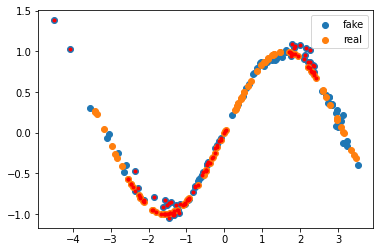

Epoch 4800 generator loss=0.708,discriminator loss=0.687
Accuracy real 0.43 accuracy fake 0.41


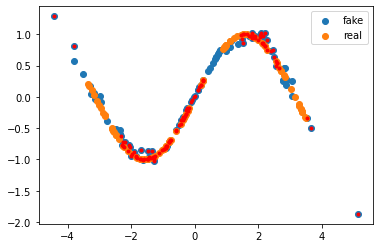

Epoch 4900 generator loss=0.712,discriminator loss=0.682
Accuracy real 0.39 accuracy fake 0.4


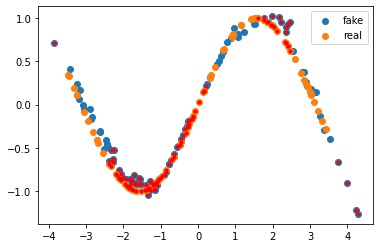

Done


In [11]:
# Main loop - run steps and visualize for every 100 epochs
epochs = 5000
for epoch in range(epochs):
    gl,dl = do_step(150)
    if epoch % 100 == 0:
       show_results()
print("Done")

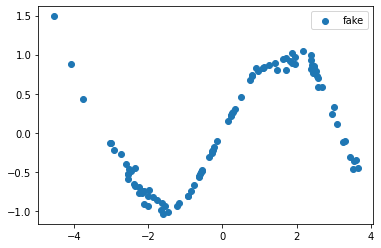

In [12]:
# test the generator
num_examples_to_generate = 100
    
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fake_points = generator(seed, training=False)
plt.scatter(fake_points[:,0],fake_points[:,1] , label='fake')
plt.legend()
plt.show()  


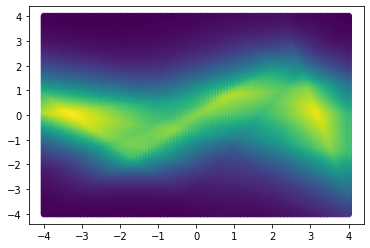

In [13]:
vals = [(x,y) for x in np.linspace(-4,4,100) for y in np.linspace(-4,4,100)]
vals = np.array(vals)
preds = discriminator.predict(vals)
plt.scatter(vals[:,0],vals[:,1] , c=preds[:])
plt.show()